# Deutsch's algorithm

In [1]:
from qiskit import __version__
print(__version__)

from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister

/var/folders/p8/wytng6t53dl_gcrnlz01_zn00000gn/T/ipykernel_82808/1295174619.py:1: DeprecationWarning: Using Qiskit with Python 3.9 is deprecated as of the 2.1.0 release. Support for running Qiskit with Python 3.9 will be removed in the 2.3.0 release, which coincides with when Python 3.9 goes end of life.
  from qiskit import __version__


2.1.1


#### Define deutsch's algorithm
![deutsch](../Images/02.deutsch's-algo.png)

In [2]:
def deutsch_function(case: int):
    # This function generates a quantum circuit for one of the 4 functions
    # from one bit to one bit

    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")

    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f

Next we will create the actual quantum circuit for Deutsch's algorithm, substituting the query gate with a quantum circuit implementation given as an argument. Shortly we'll plug in one of the four circuits defined by the function we defined earlier.

In [3]:
def compile_circuit(function: QuantumCircuit):
    # Compiles a circuit for use in Deutsch's algorithm.

    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)

    qc.x(n)
    qc.h(range(n + 1))

    qc.barrier()
    qc.compose(function, inplace=True)
    qc.barrier()

    qc.h(range(n))
    qc.measure(range(n), range(n))

    return qc

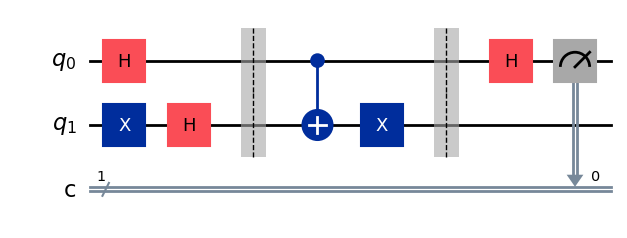

In [4]:
display(compile_circuit(deutsch_function(3)).draw(output="mpl"))

In [5]:
def deutsch_algorithm(function: QuantumCircuit):
    # Determine if a one-bit function is constant or balanced.

    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if measurements[0] == "0":
        return "constant"
    return "balanced"

f = deutsch_function(1)
display(deutsch_algorithm(f))

'constant'

# Deutsch-Jozsa problem

In [6]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np

In [7]:
def dj_query(num_qubits):
    # Create a circuit implementing for a query gate for a random function
    # satisfying the promise for the Deutsch-Jozsa problem.

    qc = QuantumCircuit(num_qubits + 1)

    if np.random.randint(0, 2):
        # Flip output qubit with 50% chance
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance
        return qc

    # Choose half the possible input strings
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )
    print(on_states)

    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        """
        Explain for this step
        For example: state = 6 = 110 -> q0 = 0; q1 = q2 = 1;
        only input state 001 -> i0 = 1; i1 = i2 = 0;
        q1 = 1 -> flip i1 to 1
        q2 = 1 -> flip i2 to 1
        -> flip output qubit
        """
        qc.barrier()  # Barriers are added to help visualize how the functions are created.
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits) # mcx only trigger when all controled bits is 1
        qc = add_cx(qc, f"{state:0b}")

    qc.barrier()

    return qc

[3 1 6 5]


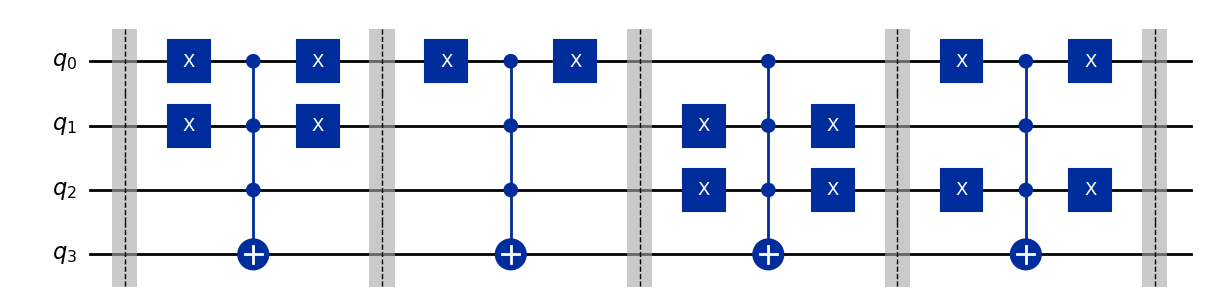

In [8]:
display(dj_query(3).draw(output="mpl"))

In [9]:
def compile_circuit(function: QuantumCircuit):
    # Compiles a circuit for use in the Deutsch-Jozsa algorithm.

    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

In [10]:
def dj_algorithm(function: QuantumCircuit):
    # Determine if a function is constant or balanced.

    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if "1" in measurements[0]:
        return "balanced"
    return "constant"

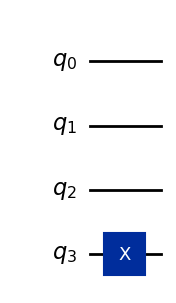

'constant'

In [11]:
f = dj_query(3)
display(f.draw("mpl"))
display(dj_algorithm(f))

## Binary Dot Product and Bernstein-Vazirani Problem

#### Notation

First let's introduce some notation. For any two binary strings $x = x_{n-1} \cdots x_0$ and $y = y_{n-1} \cdots y_0$ of length $n$, we define

$$x \cdot y = x_{n-1} y_{n-1} \oplus \cdots \oplus x_0 y_0$$

We'll refer to this operation as the **binary dot product**. 

An alternative way to define it is like so:

$$x \cdot y = \begin{cases}
1 & \text{if } x_{n-1} y_{n-1} + \cdots + x_0 y_0 \text{ is odd} \\
0 & \text{if } x_{n-1} y_{n-1} + \cdots + x_0 y_0 \text{ is even}
\end{cases}$$

Notice that this is a symmetric operation, meaning that the result doesn't change if we swap $x$ and $y$, so we're free to do that whenever it's convenient. Sometimes it's useful to think about the binary dot product $x \cdot y$ as being the parity of the bits of $x$ in positions where the string $y$ has a $1$, or equivalently, the parity of the bits of $y$ in positions where the string $x$ has a $1$.

#### Bernstein-Vazirani Problem

With this notation in hand we can now define the Bernstein-Vazirani problem.

**Bernstein-Vazirani Problem**

- **Input:** a function $f: \{0,1\}^n \to \{0,1\}$
- **Promise:** there exists a binary string $s = s_{n-1} \cdots s_0$ for which $f(x) = s \cdot x$ for all $x \in \{0,1\}^n$
- **Output:** the string $s$

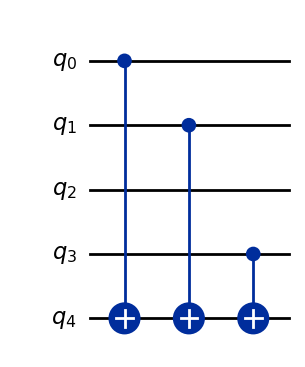

In [12]:
def bv_query(s):
    """f(x) = s.x"""
    # Create a quantum circuit implementing a query gate for the
    # Bernstein-Vazirani problem.

    qc = QuantumCircuit(len(s) + 1)
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(index, len(s))
    return qc

display(bv_query("1011").draw(output="mpl"))

In [13]:
def bv_algorithm(function: QuantumCircuit):
    qc = compile_circuit(function)
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    return result.get_memory()[0]

display(bv_algorithm(bv_query("1011")))

'1011'

## Simon's Problem

#### 1. Problem Definition

The input function for Simon's problem takes the form:

$$f: \Sigma^n \to \Sigma^m$$

for positive integers $n$ and $m$. We could restrict our attention to the case $m = n$ in the interest of simplicity, but there's little to be gained in making this assumption — Simon's algorithm and its analysis are basically the same either way.

**Simon's Problem**

**Input**: A function $f: \Sigma^n \to \Sigma^m$

**Promise**: There exists a string $s \in \Sigma^n$ such that:
$$[f(x) = f(y)] \Leftrightarrow [(x = y) \vee (x \oplus s = y)]$$
for all $x, y \in \Sigma^n$

**Output**: The string $s$

#### 2. Understanding the Promise

We'll unpack the promise to better understand what it says momentarily, but first let's be clear that it requires that $f$ has a very special structure — so most functions won't satisfy this promise. It's also fitting to acknowledge that this problem isn't intended to have practical importance. Rather, it's a somewhat artificial problem tailor-made to be easy for quantum computers and hard for classical computers.

There are two main cases: the first case is that $s$ is the all-zero string $0^n$, and the second case is that $s$ is not the all-zero string.

**Case 1: $s = 0^n$**

If $s$ is the all-zero string, then we can simplify the if and only if statement in the promise so that it reads:
$$[f(x) = f(y)] \Leftrightarrow [x = y]$$

This condition is true for all strings $x, y \in \Sigma^n$ if and only if $f$ is a **one-to-one function**.

Case 2: $s \neq 0^n$**

If $s$ is not the all-zero string, then the promise being satisfied for this string implies that $f$ is **two-to-one**, meaning that for every possible output string of $f$, there are exactly two input strings that cause $f$ to output that string. Moreover, these two input strings must take the form $x$ and $x \oplus s$ for some string $x$.

#### 3. Uniqueness of Solution

It's important to recognize that there can only be one string $s$ that works if the promise is met, so there's always a unique correct answer for functions that satisfy the promise.

#### 4. Example

Here's an example of a function taking the form $f: \Sigma^3 \to \Sigma^5$ that satisfies the promise for the string $s = 011$.

$$\begin{align}
f(000) &= 10011 \\
f(001) &= 00101 \\
f(010) &= 00101 \\
f(011) &= 10011 \\
f(100) &= 11010 \\
f(101) &= 00001 \\
f(110) &= 00001 \\
f(111) &= 11010
\end{align}$$

#### **Analysis of the Example**

There are 8 different input strings and 4 different output strings, each of which occurs twice — so this is a **two-to-one function**. Moreover, for any two different input strings that produce the same output string, we see that the bitwise XOR of these two input strings is equal to $011$, which is equivalent to saying that either one of them equals the other XORed with $s$.

#### **Verification**

Let's verify the promise condition for this example:

| Input Pair | Output | XOR of Inputs | Equals $s = 011$? |
|------------|--------|---------------|-------------------|
| $000, 011$ | $10011$ | $000 \oplus 011 = 011$ | ✓ |
| $001, 010$ | $00101$ | $001 \oplus 010 = 011$ | ✓ |
| $100, 111$ | $11010$ | $100 \oplus 111 = 011$ | ✓ |
| $101, 110$ | $00001$ | $101 \oplus 110 = 011$ | ✓ |

In [14]:
def simon_function(s: str):
    # Create a QuantumCircuit implementing a query gate for Simon problem obeying the
    # promise for the hidden string `s`

    # The quantum circuit will have 2n qubits for n being the length of s
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # Define a random permutation of all n bit strings. This permutation will
    # effectively hide the string s.
    pi = np.random.permutation(2**n)

    # Now we'll define a query gate explicitly. The idea is to first define a function
    # g(x) = min{x,x ^ s}, which is a very simple function that satisfies the promise.
    # (The operation ^ is the bitwise XOR.) Then we take f to be the composition of g
    # and the random permutation pi. This gives us a random function satisfying the
    # promise for s.

    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1
    print(query_gate)

    # Our circuit has just this one query gate
    qc.unitary(query_gate, range(2 * n))
    return qc

# Simon's Oracle Implementation: Complete Analysis

## Function Overview

```python
def simon_function(s: str):
    # Creates a quantum circuit implementing Simon's oracle
    # Input: s = hidden string (e.g., '101')
    # Output: QuantumCircuit satisfying Simon's promise
```

## Step-by-Step Breakdown

### 1. Circuit Setup
```python
n = len(s)
qc = QuantumCircuit(2 * n)
```

**Purpose**: Create quantum circuit with **2n qubits**
- **First n qubits**: Input register $|x\rangle$
- **Last n qubits**: Output register $|y\rangle$

**Example**: For `s = '101'` (n=3), we get 6 qubits total

### 2. Random Permutation Generation
```python
pi = np.random.permutation(2**n)
```

**Purpose**: Create a random shuffling of output values
- **Input**: Array $[0, 1, 2, \ldots, 2^n-1]$
- **Output**: Random permutation of these values
- **Effect**: Hides the structure from classical observation

**Example**: For n=3, might generate `π = [3,7,1,0,5,2,6,4]`

### 3. The Clever Function Construction

The algorithm constructs $f(x) = \pi(g(x))$ where:
$$g(x) = \min\{x, x \oplus s\}$$

#### Why This Works

**Mathematical Property**: For any inputs $a$ and $b$:
$$g(a) = g(b) \Leftrightarrow [a = b \text{ OR } a = b \oplus s]$$

**Proof**:
- If $a = b$: Obviously $g(a) = g(b)$ ✓
- If $a = b \oplus s$: Then $a \oplus s = b$, so $\{a, a \oplus s\} = \{a, b\} = \{b \oplus s, b\}$
  - Therefore $\min\{a, a \oplus s\} = \min\{b \oplus s, b\}$ ✓

#### Example with s = '11'

| x (binary) | x (decimal) | x ⊕ s | g(x) = min{x, x⊕s} |
|------------|-------------|-------|-------------------|
| 00 | 0 | 3 | 0 |
| 01 | 1 | 2 | 1 |
| 10 | 2 | 1 | 1 |
| 11 | 3 | 0 | 0 |

**Verification**:
- $g(00) = g(11) = 0$ ✓ (since $00 \oplus 11 = 11$)
- $g(01) = g(10) = 1$ ✓ (since $01 \oplus 11 = 10$)

### 4. Unitary Matrix Construction

```python
query_gate = np.zeros((4**n, 4**n))
for x in range(2**n):
    for y in range(2**n):
        z = y ^ pi[min(x, x ^ int(s, 2))]
        query_gate[x + 2**n * z, x + 2**n * y] = 1
```

#### Matrix Dimensions
- **Size**: $(4^n) \times (4^n) = (2^{2n}) \times (2^{2n})$
- **Basis states**: $|xy\rangle$ where $x,y \in \{0,1\}^n$
- **Indexing**: State $|x\rangle|y\rangle$ maps to index $x + 2^n \cdot y$

#### Transformation Logic
For each basis state $|x\rangle|y\rangle$:

1. **Compute** $g(x) = \min\{x, x \oplus s\}$
2. **Apply permutation** $\pi[g(x)]$
3. **Calculate output** $z = y \oplus \pi[g(x)]$
4. **Set matrix element** `query_gate[x + 2^n * z, x + 2^n * y] = 1`

This implements: $U_f|x\rangle|y\rangle = |x\rangle|y \oplus f(x)\rangle$

Where $f(x) = \pi(g(x)) = \pi(\min\{x, x \oplus s\})$

### 5. Final Circuit Assembly
```python
qc.unitary(query_gate, range(2 * n))
return qc
```

**Purpose**: Convert the unitary matrix into a quantum gate and add it to the circuit.

In [15]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import galois

In [16]:
def simon_measurements(problem: QuantumCircuit, k: int):
    # This is the quantum part of Simon's algorithm. Given a `QuantumCircuit` that
    # implements f, gets k measurement outcomes to be post-processed later.

    n = problem.num_qubits // 2

    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    result = AerSimulator().run(qc, shots=k, memory=True).result()
    return result.get_memory()

In [17]:
def simon_algorithm(problem: QuantumCircuit):
    # Given a `QuantumCircuit` that implements a query gate for Simon problem, return
    # the hidden string `s`.

    # Quantum part: run the circuit defined previously k times and gather the measurement
    # results. Replace +10 by +r for any nonnegative integer r depending on desired
    # confidence.

    measurements = simon_measurements(problem, k=problem.num_qubits // 2 + 10)
    print(measurements)

    # Classical post-processing:

    # 1. Convert measurements of form '11101' to 2D-array of integers
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    # 2. Interpret matrix as using arithmetic mod 2, and find null space
    null_space = galois.GF(2)(matrix).null_space()

    # 3. Convert back to a string
    print("Guess for hidden string s: ")
    if len(null_space) == 0:
        # No non-trivial solution; `s` is all-zeros
        return "0" * len(measurements[0])
    return "".join(np.array(null_space[0]).astype(str))

In [18]:
display(simon_algorithm(simon_function("10011")))

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['01100', '01000', '10010', '10001', '11101', '11110', '11110', '01100', '00000', '00011', '11110', '01011', '10101', '11010', '00100']


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Guess for hidden string s: 


'10011'

## QPE

#### 1 bit precision

In [19]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
from math import pi

In [20]:
def qpe_1bit_function(theta):
   """Create a 1-bit QPE oracle function"""
   qc = QuantumCircuit(2)
   # Controlled phase gate: if control=1, apply phase e^(2πiθ) to target
   qc.cp(2 * pi * theta, 0, 1)
   return qc

def qpe_1bit_compile_circuit(function: QuantumCircuit):
   """Compile circuit for 1-bit quantum phase estimation"""
   qc = QuantumCircuit(2, 1)
   
   # Prepare eigenstate |1⟩ on target qubit
   qc.x(1)
   
   # Hadamard on control qubit
   qc.h(0)
   
   qc.barrier()
   qc.compose(function, inplace=True)
   qc.barrier()
   
   # Hadamard on control qubit
   qc.h(0)
   
   # Measure control qubit
   qc.measure(0, 0)
   
   return qc

def qpe_1bit_algorithm(function: QuantumCircuit):
    """Determine the phase θ with 1-bit precision"""
    qc = qpe_1bit_compile_circuit(function)
    
    result = AerSimulator().run(qc, shots=1000, memory=True).result()
    measurements = result.get_memory()
    
    count_0 = measurements.count('0')
    count_1 = measurements.count('1')
    
    print(f"Measured '0': {count_0} times")
    print(f"Measured '1': {count_1} times")
    
    if count_0 > count_1:
        return "0.0"  # θ closer to 0 (or 1 due to periodicity)
    return "0.5"

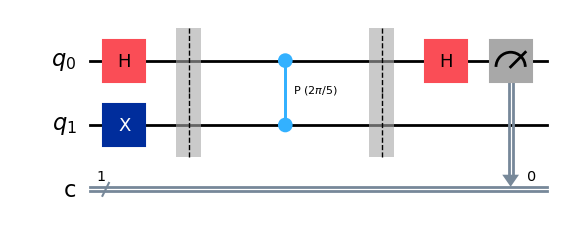

In [21]:
display(qpe_1bit_compile_circuit(qpe_1bit_function(0.2)).draw(output="mpl"))

In [22]:
display(qpe_1bit_algorithm(qpe_1bit_function(0.8)))

Measured '0': 633 times
Measured '1': 367 times


'0.0'

#### 2 bits precision

In [23]:
def qpe_2bit_function(theta):
    """Create a 2-bit QPE oracle function"""
    qc = QuantumCircuit(3)
    # Apply controlled-U^1 and controlled-U^2
    qc.cp(2 * pi * theta, 0, 2)        # U^1
    qc.cp(2 * pi * theta * 2, 1, 2)    # U^2
    return qc

def qpe_2bit_compile_circuit(function: QuantumCircuit):
    """Compile circuit for 2-bit quantum phase estimation"""
    qc = QuantumCircuit(3, 2)
    
    # Prepare eigenstate |1⟩ on target qubit
    qc.x(2)
    
    # Hadamard on control qubits
    qc.h([0, 1])
    
    qc.barrier()
    qc.compose(function, inplace=True)
    qc.barrier()
    
    # Inverse QFT on control qubits
    qc.h(1)
    qc.cp(-pi/2, 0, 1)
    qc.h(0)
    qc.swap(0, 1)
    
    # Measure control qubits
    qc.measure([0, 1], [0, 1])
    
    return qc

def qpe_2bit_algorithm(function: QuantumCircuit):
    """Determine the phase θ with 2-bit precision"""
    qc = qpe_2bit_compile_circuit(function)
    
    result = AerSimulator().run(qc, shots=1000).result()
    counts = result.get_counts()
    print(counts)
    
    # Find most frequent measurement
    best_result = max(counts.items(), key=lambda x: x[1])
    best_bitstring = best_result[0]
    
    # Convert binary to decimal phase
    phase_estimate = int(best_bitstring, 2) / 4
    return f"{phase_estimate:.3f}"

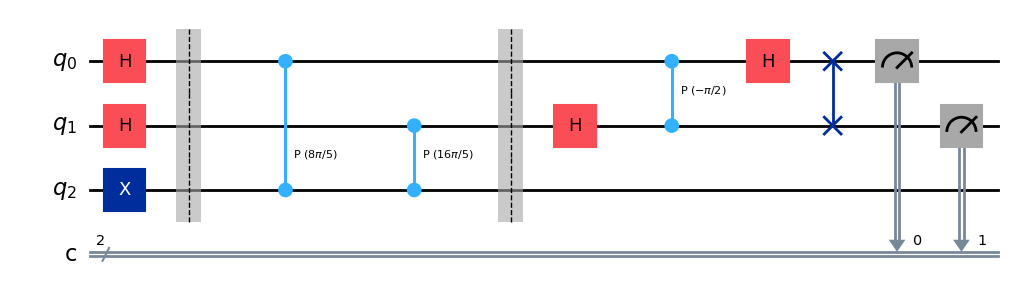

{'01': 27, '10': 30, '00': 48, '11': 895}


'0.750'

In [24]:
display(qpe_2bit_compile_circuit(qpe_2bit_function(0.8)).draw(output="mpl"))
display(qpe_2bit_algorithm(qpe_2bit_function(0.8)))

#### Quantum Fourier Transform (QFT)

The Quantum Fourier Transform is one of the most important quantum algorithms, forming the basis for many quantum algorithms including phase estimation and Shor's factoring algorithm.

**Mathematical Definition**

The QFT is defined using the primitive N-th root of unity:

$$\omega_N = e^{2\pi i/N} = \cos(2\pi/N) + i\sin(2\pi/N)$$

This represents a point on the unit circle at angle 2π/N radians.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from math import pi, cos, sin, sqrt

def omega_n(N):
    """Calculate the primitive N-th root of unity"""
    return np.exp(2j * pi / N)

def show_omega_examples():
    """Show examples of omega_N for different values of N"""
    print("Examples of ω_N:")
    
    examples = [1, 2, 3, 4, 8, 16, 100]
    for N in examples:
        w = omega_n(N)
        print(f"ω_{N} = {w:.3f}")
    
show_omega_examples()

Examples of ω_N:
ω_1 = 1.000-0.000j
ω_2 = -1.000+0.000j
ω_3 = -0.500+0.866j
ω_4 = 0.000+1.000j
ω_8 = 0.707+0.707j
ω_16 = 0.924+0.383j
ω_100 = 0.998+0.063j


In [26]:
def create_qft_matrix(N):
    """Create the N-dimensional QFT matrix"""
    omega = omega_n(N)
    matrix = np.zeros((N, N), dtype=complex)
    
    for x in range(N):
        for y in range(N):
            matrix[x, y] = (omega ** (x * y)) / sqrt(N)
    
    return matrix

def show_small_qft_matrices():
    """Display QFT matrices for small dimensions"""
    for N in [1, 2, 3, 4]:
        print(f"\nQFT_{N}:")
        qft_matrix = create_qft_matrix(N)
        
        # Round for cleaner display
        qft_rounded = np.round(qft_matrix, 3)
        print(qft_rounded)
        
        # Verify it's unitary
        should_be_identity = qft_matrix @ qft_matrix.conj().T
        is_unitary = np.allclose(should_be_identity, np.eye(N))
        print(f"Is unitary: {is_unitary}")

show_small_qft_matrices()


QFT_1:
[[1.+0.j]]
Is unitary: True

QFT_2:
[[ 0.707+0.j  0.707+0.j]
 [ 0.707+0.j -0.707+0.j]]
Is unitary: True

QFT_3:
[[ 0.577+0.j   0.577+0.j   0.577+0.j ]
 [ 0.577+0.j  -0.289+0.5j -0.289-0.5j]
 [ 0.577+0.j  -0.289-0.5j -0.289+0.5j]]
Is unitary: True

QFT_4:
[[ 0.5+0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0. +0.5j -0.5+0.j  -0. -0.5j]
 [ 0.5+0.j  -0.5+0.j   0.5-0.j  -0.5+0.j ]
 [ 0.5+0.j  -0. -0.5j -0.5+0.j   0. +0.5j]]
Is unitary: True


#### QFT Circuit Implementation

For N = 2^m, we can implement QFT efficiently with a quantum circuit using O(m²) gates.

In [27]:
def qft_circuit(n_qubits):
    """Create QFT circuit for n qubits"""
    qc = QuantumCircuit(n_qubits)
    
    for i in range(n_qubits):
        # Apply Hadamard to qubit i
        qc.h(i)
        
        # Apply controlled rotations
        for j in range(i + 1, n_qubits):
            angle = pi / (2 ** (j - i))
            qc.cp(angle, j, i)
    
    # Reverse the order of qubits (swap)
    for i in range(n_qubits // 2):
        qc.swap(i, n_qubits - 1 - i)
    
    return qc

def inverse_qft_circuit(n_qubits):
    """Create inverse QFT circuit for n qubits"""
    qc = QuantumCircuit(n_qubits)
    
    # Reverse the swaps first
    for i in range(n_qubits // 2):
        qc.swap(i, n_qubits - 1 - i)
    
    # Apply inverse operations in reverse order
    for i in range(n_qubits - 1, -1, -1):
        # Apply controlled rotations with negative angles
        for j in range(n_qubits - 1, i, -1):
            angle = -pi / (2 ** (j - i))
            qc.cp(angle, j, i)
        
        # Apply Hadamard to qubit i
        qc.h(i)
    
    return qc

In [28]:
def create_qft_matrix(n_qubits):
    """Create manual QFT matrix for n qubits"""
    N = 2 ** n_qubits
    omega = np.exp(2j * pi / N)
    
    matrix = np.zeros((N, N), dtype=complex)
    for x in range(N):
        for y in range(N):
            matrix[x, y] = (omega ** (x * y)) / sqrt(N)
    
    return matrix

def qpe_manual_qft_function(theta, n_precision=3):
    """Create QPE oracle function"""
    qc = QuantumCircuit(n_precision + 1)
    
    # Apply controlled-U^(2^j) operations
    for j in range(n_precision):
        power = 2 ** j
        phase = 2 * pi * theta * power
        qc.cp(phase, j, n_precision)
    
    return qc

def qpe_manual_qft_compile_circuit(function: QuantumCircuit):
    """Compile QPE circuit using manual QFT matrix"""
    n_precision = function.num_qubits - 1
    n_total = function.num_qubits
    qc = QuantumCircuit(n_total, n_precision)
    
    # Prepare eigenstate |1⟩ on target qubit
    qc.x(n_precision)
    
    # Create superposition on precision qubits
    qc.h(range(n_precision))
    
    qc.barrier()
    qc.compose(function, inplace=True)
    qc.barrier()
    
    # Apply inverse QFT using manual matrix
    inverse_qft_matrix = create_qft_matrix(n_precision).conj().T
    qc.unitary(inverse_qft_matrix, range(n_precision), label='IQFT')
    
    # Measure precision qubits
    qc.measure(range(n_precision), range(n_precision))
    
    return qc

def qpe_manual_qft_algorithm(function: QuantumCircuit):
    """QPE algorithm using manual QFT matrix"""
    qc = qpe_manual_qft_compile_circuit(function)
    
    result = AerSimulator().run(qc, shots=1000).result()
    counts = result.get_counts()
    
    print("Measurement counts:")
    for bitstring, count in sorted(counts.items()):
        prob = count / 1000
        n_precision = len(bitstring)
        estimate = int(bitstring, 2) / (2 ** n_precision)
        print(f"  {bitstring}: {count:3d} ({prob:.3f}) → θ = {estimate:.3f}")
    
    # Find most frequent measurement
    best_result = max(counts.items(), key=lambda x: x[1])
    best_bitstring = best_result[0]
    
    n_precision = len(best_bitstring)
    phase_estimate = int(best_bitstring, 2) / (2 ** n_precision)
    
    return f"{phase_estimate:.3f}"

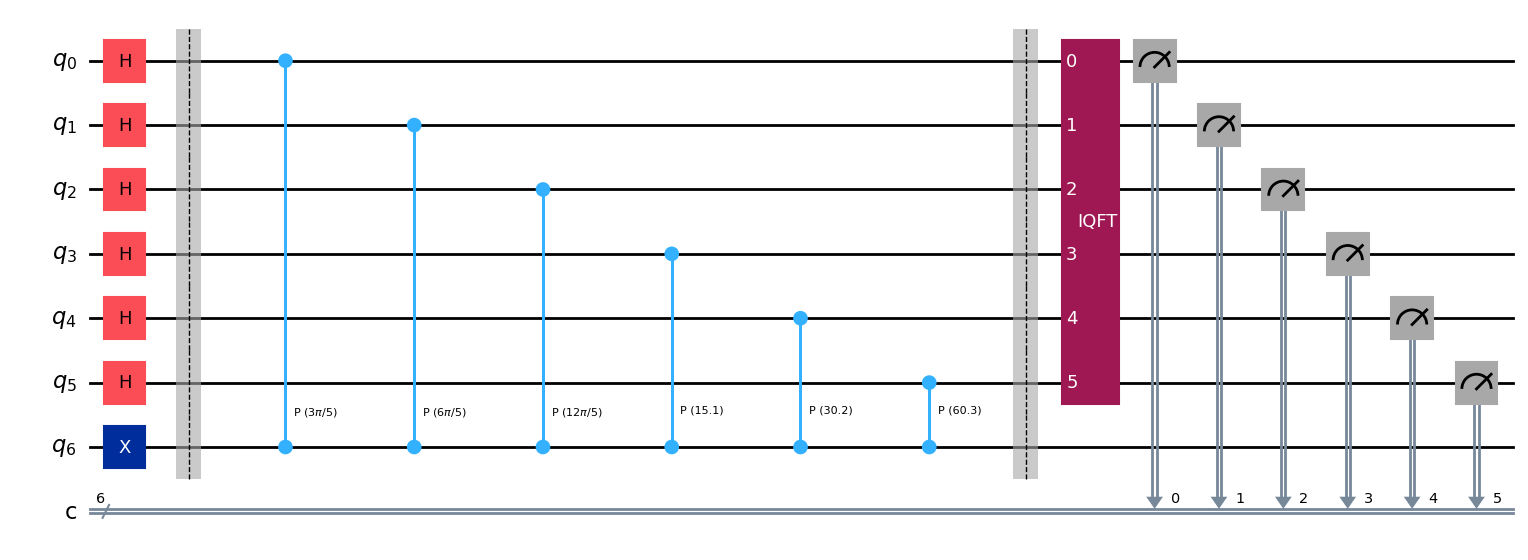

Measurement counts:
  000100:   1 (0.001) → θ = 0.062
  000101:   1 (0.001) → θ = 0.078
  000111:   1 (0.001) → θ = 0.109
  001011:   2 (0.002) → θ = 0.172
  001110:   2 (0.002) → θ = 0.219
  010000:   2 (0.002) → θ = 0.250
  010001:  10 (0.010) → θ = 0.266
  010010:  24 (0.024) → θ = 0.281
  010011: 877 (0.877) → θ = 0.297
  010100:  58 (0.058) → θ = 0.312
  010101:   9 (0.009) → θ = 0.328
  010110:   4 (0.004) → θ = 0.344
  010111:   2 (0.002) → θ = 0.359
  011000:   1 (0.001) → θ = 0.375
  011001:   1 (0.001) → θ = 0.391
  100010:   1 (0.001) → θ = 0.531
  100101:   2 (0.002) → θ = 0.578
  100110:   1 (0.001) → θ = 0.594
  111000:   1 (0.001) → θ = 0.875


'0.297'

In [29]:
theta = 0.3
display(qpe_manual_qft_compile_circuit(qpe_manual_qft_function(theta, n_precision=6)).draw(output="mpl"))
display(qpe_manual_qft_algorithm(qpe_manual_qft_function(theta, n_precision=6)))

# Shor algorithm

In [30]:

from abc import ABC
import inspect
import pprint
from typing import List
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class AlgorithmResult(ABC):
    """Abstract Base Class for algorithm results."""

    def __str__(self) -> str:
        result = {}
        for name, value in inspect.getmembers(self):
            if (
                not name.startswith("_")
                and not inspect.ismethod(value)
                and not inspect.isfunction(value)
                and hasattr(self, name)
            ):

                result[name] = value

        return pprint.pformat(result, indent=4)

    def combine(self, result: "AlgorithmResult") -> None:
        """
        Any property from the argument that exists in the receiver is
        updated.
        Args:
            result: Argument result with properties to be set.
        Raises:
            TypeError: Argument is None
        """
        if result is None:
            raise TypeError("Argument result expected.")
        if result == self:
            return

        # find any result public property that exists in the receiver
        for name, value in inspect.getmembers(result):
            if (
                not name.startswith("_")
                and not inspect.ismethod(value)
                and not inspect.isfunction(value)
                and hasattr(self, name)
            ):
                try:
                    setattr(self, name, value)
                except AttributeError:
                    # some attributes may be read only
                    pass


class ShorResult(AlgorithmResult):
    """Shor Result."""

    def __init__(self) -> None:
        super().__init__()
        self._factors = []
        self._total_counts = 0
        self._successful_counts = 0

    @property
    def factors(self) -> List[List[int]]:
        """returns factors"""
        return self._factors

    @factors.setter
    def factors(self, value: List[List[int]]) -> None:
        """set factors"""
        self._factors = value

    @property
    def total_counts(self) -> int:
        """returns total counts"""
        return self._total_counts

    @total_counts.setter
    def total_counts(self, value: int) -> None:
        """set total counts"""
        self._total_counts = value

    @property
    def successful_counts(self) -> int:
        """returns successful counts"""
        return self._successful_counts

    @successful_counts.setter
    def successful_counts(self, value: int) -> None:
        """set successful counts"""
        self._successful_counts = value
        
def is_power(N: int, return_decomposition: bool = True):
    for p in range(2, int(N.bit_length()) + 1):
        b = round(N ** (1/p))
        if b ** p == N:
            if return_decomposition:
                return True, b, p
            else:
                return True
    if return_decomposition:
        return False, None, None
    else:
        return False

In [31]:
import array
import fractions
import math
import numpy as np
import sys
from typing import List, Optional, Tuple, Union
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, Gate, Instruction
from qiskit.circuit.library import QFT  # Updated import
from qiskit.quantum_info import partial_trace
from qiskit_aer import AerSimulator
from qiskit import transpile

class Shor:
    """Shor's factoring algorithm."""
    
    def __init__(self, backend: Optional[Union[AerSimulator]] = None) -> None:
        """
        Args:
            backend: Backend
        """
        self._backend = None
        if backend:
            self.backend = backend
            
    @property
    def backend(self) -> Optional[Union[AerSimulator]]:
        """Returns backend."""
        return self._backend

    @backend.setter
    def backend(self, backend: Union[AerSimulator]) -> None:
        """Sets backend."""
        self._backend = backend
        
    @staticmethod
    def _get_angles(a: int, n: int) -> np.ndarray:
        """Calculates the array of angles to be used in the addition in Fourier Space."""
        bits_little_endian = (bin(int(a))[2:].zfill(n))[::-1]

        angles = np.zeros(n)
        for i in range(n):
            for j in range(i + 1):
                k = i - j
                if bits_little_endian[j] == "1":
                    angles[i] += pow(2, -k)

        return angles * np.pi
    
    @staticmethod
    def _phi_add_gate(angles: Union[np.ndarray, ParameterVector]) -> Gate:
        """Gate that performs addition by a in Fourier Space."""
        circuit = QuantumCircuit(len(angles), name="phi_add_a")
        for i, angle in enumerate(angles):
            circuit.p(angle, i)
        return circuit.to_gate()
    
    def _double_controlled_phi_add_mod_N(self, angles: Union[np.ndarray, ParameterVector], 
                                        c_phi_add_N: Gate, iphi_add_N: Gate, 
                                        qft: Gate, iqft: Gate) -> QuantumCircuit:
        """Creates a circuit which implements double-controlled modular addition by a."""
        ctrl_qreg = QuantumRegister(2, "ctrl")
        b_qreg = QuantumRegister(len(angles), "b")
        flag_qreg = QuantumRegister(1, "flag")
        
        circuit = QuantumCircuit(ctrl_qreg, b_qreg, flag_qreg, name="ccphi_add_a_mod_N")
        
        cc_phi_add_a = self._phi_add_gate(angles).control(2)
        cc_iphi_add_a = cc_phi_add_a.inverse()
        
        circuit.append(cc_phi_add_a, [*ctrl_qreg, *b_qreg])
        circuit.append(iphi_add_N, b_qreg)
        circuit.append(iqft, b_qreg)
        
        circuit.cx(b_qreg[-1], flag_qreg[0])
        
        circuit.append(qft, b_qreg)
        
        circuit.append(c_phi_add_N, [*flag_qreg, *b_qreg])
        circuit.append(cc_iphi_add_a, [*ctrl_qreg, *b_qreg])
        
        circuit.append(iqft, b_qreg)
        
        circuit.x(b_qreg[-1])
        circuit.cx(b_qreg[-1], flag_qreg[0])
        circuit.x(b_qreg[-1])
        
        circuit.append(qft, b_qreg)
        circuit.append(cc_phi_add_a, [*ctrl_qreg, *b_qreg])
        
        return circuit
    
    def _controlled_multiple_mod_N(self, n: int, N: int, a: int, 
                                  c_phi_add_N: Gate, iphi_add_N: Gate, 
                                  qft: Gate, iqft: Gate) -> Instruction:
        """Implements modular multiplication by a as an instruction."""
        ctrl_qreg = QuantumRegister(1, "ctrl")
        x_qreg = QuantumRegister(n, "x")
        b_qreg = QuantumRegister(n + 1, "b")
        flag_qreg = QuantumRegister(1, "flag")
        circuit = QuantumCircuit(ctrl_qreg, x_qreg, b_qreg, flag_qreg, name="cmult_a_mod_N")
        
        angle_params = ParameterVector("angles", length=n + 1)
        modulo_adder = self._double_controlled_phi_add_mod_N(
            angle_params, c_phi_add_N, iphi_add_N, qft, iqft
        )
        
        def append_adder(adder: QuantumCircuit, constant: int, idx: int):
            partial_constant = (pow(2, idx, N) * constant) % N
            angles = self._get_angles(partial_constant, n + 1)
            bound = adder.assign_parameters({angle_params: angles})
            circuit.append(bound, [*ctrl_qreg, x_qreg[idx], *b_qreg, *flag_qreg])
            
        circuit.append(qft, b_qreg)
        
        for i in range(n):
            append_adder(modulo_adder, a, i)
            
        circuit.append(iqft, b_qreg)
        
        for i in range(n):
            circuit.cswap(ctrl_qreg, x_qreg[i], b_qreg[i])
            
        circuit.append(qft, b_qreg)
        
        a_inv = pow(a, -1, mod=N) if sys.version_info >= (3, 8) else self.modinv(a, N)
        modulo_adder_inv = modulo_adder.inverse()
        
        for i in reversed(range(n)):
            append_adder(modulo_adder_inv, a_inv, i)
            
        circuit.append(iqft, b_qreg)
        return circuit.to_instruction()
    
    def _power_mod_N(self, n: int, N: int, a: int) -> Instruction:
        """Implements modular exponentiation a^x as an instruction."""
        up_qreg = QuantumRegister(2 * n, name="up")
        down_qreg = QuantumRegister(n, name="down")
        aux_qreg = QuantumRegister(n + 2, name="aux")

        circuit = QuantumCircuit(up_qreg, down_qreg, aux_qreg, name=f"power_mod_N_{a}_{N}")

        qft = QFT(n + 1, do_swaps=False).to_gate()
        iqft = qft.inverse()

        phi_add_N = self._phi_add_gate(self._get_angles(N, n + 1))
        iphi_add_N = phi_add_N.inverse()
        c_phi_add_N = phi_add_N.control(1)

        for i in range(2 * n):
            partial_a = pow(a, pow(2, i), N)
            modulo_multiplier = self._controlled_multiple_mod_N(
                n, N, partial_a, c_phi_add_N, iphi_add_N, qft, iqft
            )
            circuit.append(modulo_multiplier, [up_qreg[i], *down_qreg, *aux_qreg])

        return circuit.to_instruction()
    
    @staticmethod
    def _validate_input(N: int, a: int):
        """Check parameters of the algorithm."""
        if N < 1 or N % 2 == 0:
            raise ValueError("The input needs to be an odd integer greater than 1.")
        if a >= N or math.gcd(a, N) != 1:
            raise ValueError("The integer a needs to satisfy a < N and gcd(a, N) = 1.")
        
    def construct_circuit(self, N: int, a: int = 2, measurement: bool = False) -> QuantumCircuit:
        """Construct quantum part of the algorithm."""
        self._validate_input(N, a)

        n = N.bit_length()

        up_qreg = QuantumRegister(2 * n, name="up")
        down_qreg = QuantumRegister(n, name="down")
        aux_qreg = QuantumRegister(n + 2, name="aux")

        circuit = QuantumCircuit(up_qreg, down_qreg, aux_qreg, name=f"Shor(N={N}, a={a})")

        circuit.h(up_qreg)
        circuit.x(down_qreg[0])

        modulo_power = self._power_mod_N(n, N, a)
        circuit.append(modulo_power, circuit.qubits)

        iqft = QFT(len(up_qreg)).inverse().to_gate()
        circuit.append(iqft, up_qreg)

        if measurement:
            up_cqreg = ClassicalRegister(2 * n, name="m")
            circuit.add_register(up_cqreg)
            circuit.measure(up_qreg, up_cqreg)

        return circuit
    
    @staticmethod
    def modinv(a: int, m: int) -> int:
        """Returns the modular multiplicative inverse of a with respect to the modulus m."""
        def egcd(a: int, b: int) -> Tuple[int, int, int]:
            if a == 0:
                return b, 0, 1
            else:
                g, y, x = egcd(b % a, a)
                return g, x - (b // a) * y, y

        g, x, _ = egcd(a, m)
        if g != 1:
            raise ValueError(
                "The greatest common divisor of {} and {} is {}, so the "
                "modular inverse does not exist.".format(a, m, g)
            )
        return x % m
    
    def _get_factors(self, N: int, a: int, measurement: str) -> Optional[List[int]]:
        """Apply the continued fractions to find r and the gcd to find the desired factors."""
        x_final = int(measurement, 2)
        logger.info("In decimal, x_final value for this result is: %s.", x_final)

        if x_final <= 0:
            fail_reason = "x_final value is <= 0, there are no continued fractions."
        else:
            fail_reason = None

        T_upper = len(measurement)
        T = pow(2, T_upper)
        x_over_T = x_final / T

        i = 0
        b = array.array("i")
        t = array.array("f")

        b.append(math.floor(x_over_T))
        t.append(x_over_T - b[i])

        exponential = 0.0
        while i < N and fail_reason is None:
            if i > 0:
                b.append(math.floor(1 / t[i - 1]))
                t.append((1 / t[i - 1]) - b[i])

            denominator = self._calculate_continued_fraction(b)
            i += 1

            if denominator % 2 == 1:
                logger.debug("Odd denominator, will try next iteration of continued fractions.")
                continue

            if denominator < 1000:
                exponential = pow(a, denominator / 2)

            if exponential > 1000000000:
                fail_reason = "denominator of continued fraction is too big."
            else:
                putting_plus = int(exponential + 1)
                putting_minus = int(exponential - 1)
                one_factor = math.gcd(putting_plus, N)
                other_factor = math.gcd(putting_minus, N)

                if any(factor in {1, N} for factor in (one_factor, other_factor)):
                    logger.debug("Found just trivial factors, not good enough.")
                    if t[i - 1] == 0:
                        fail_reason = "the continued fractions found exactly x_final/(2^(2n))."
                else:
                    return sorted((one_factor, other_factor))

        logger.debug(
            "Cannot find factors from measurement %s because %s",
            measurement,
            fail_reason or "it took too many attempts.",
        )
        return None
    
    @staticmethod
    def _calculate_continued_fraction(b: array.array) -> int:
        """Calculate the continued fraction of x/T from the current terms of expansion b."""
        x_over_T = 0

        for i in reversed(range(len(b) - 1)):
            x_over_T = 1 / (b[i + 1] + x_over_T)

        x_over_T += b[0]

        frac = fractions.Fraction(x_over_T).limit_denominator()

        logger.debug("Approximation number %s of continued fractions:", len(b))
        logger.debug("Numerator:%s \t\t Denominator: %s.", frac.numerator, frac.denominator)
        return frac.denominator
    
    def factor(self, N: int, a: int = 2) -> ShorResult:
        """Execute the algorithm with improved error handling."""
        self._validate_input(N, a)
        if self.backend is None:
            raise ValueError("A Backend must be supplied to run the quantum algorithm.")
            
        result = ShorResult()
        
        # Check if the input integer N is a power
        tf, b, p = is_power(N, return_decomposition=True)
        if tf:
            logger.info("The input integer is a power: %s=%s^%s.", N, b, p)
            result.factors.append([b])
            return result
            
        if not result.factors:
            logger.debug("Running with N=%s and a=%s.", N, a)
            
            try:
                # Use statevector simulator for better compatibility
                if hasattr(self.backend, 'name') and 'statevector' in self.backend.name:
                    n = N.bit_length()
                    circuit = self.construct_circuit(N=N, a=a, measurement=False)
                    
                    # Decompose the circuit to avoid custom instruction errors
                    transpiled_circuit = transpile(circuit, 
                                                 backend=self.backend, 
                                                 optimization_level=0)
                    
                    logger.warning("Using statevector simulator - memory intensive for large N")
                    job = self.backend.run(transpiled_circuit)
                    result_data = job.result()
                    complete_state_vec = result_data.get_statevector(transpiled_circuit)
                    
                    up_qreg_density_mat = partial_trace(complete_state_vec, range(2 * n, 4 * n + 2))
                    up_qreg_density_mat_diag = np.diag(up_qreg_density_mat)
                    counts = dict()
                    for i, v in enumerate(up_qreg_density_mat_diag):
                        if not np.isclose(v, 0):
                            counts[bin(int(i))[2:].zfill(2 * n)] = abs(v) ** 2
                            
                else:
                    # Use regular simulator with measurements
                    circuit = self.construct_circuit(N=N, a=a, measurement=True)
                    # display(circuit.draw("mpl"))
                    
                    # Decompose the circuit
                    transpiled_circuit = transpile(circuit, 
                                                 backend=self.backend, 
                                                 optimization_level=1)
                    
                    job = self.backend.run(transpiled_circuit, shots=1000)
                    result_data = job.result()
                    counts = result_data.get_counts(transpiled_circuit)
                
                result.total_counts = len(counts)
                
                # Analyze each measurement result
                for measurement in list(counts.keys()):
                    logger.info("------> Analyzing result %s.", measurement)
                    factors = self._get_factors(N, a, measurement)
                    if factors:
                        logger.info("Found factors %s from measurement %s.", factors, measurement)
                        result.successful_counts += 1
                        if factors not in result.factors:
                            result.factors.append(factors)
                            
            except Exception as e:
                logger.error(f"Error during quantum execution: {e}")
                logger.info("Quantum execution failed, but this is expected for complex circuits")
                
        return result

In [32]:
# Create backend
backend = AerSimulator()

# Initialize Shor algorithm
shor = Shor(backend=backend)

# Factor N=21 with a=2
result = shor.factor(N=15, a=2)
print(result)

/var/folders/p8/wytng6t53dl_gcrnlz01_zn00000gn/T/ipykernel_82808/1768529139.py:143: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(n + 1, do_swaps=False).to_gate()
INFO:qiskit.passmanager.base_tasks:Pass: UnrollCustomDefinitions - 0.07987 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.08011 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnrollCustomDefinitions - 0.03409 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.02623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnrollCustomDefinitions - 0.14710 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.12112 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnrollCustomDefinitions - 0.02980 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.0839

{'factors': [[3, 5]], 'successful_counts': 2, 'total_counts': 4}


# Grover

# BB84 Quantum key distribution

In [33]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from datetime import datetime

# Encoding function
def encode_message(bits, bases):
    circuits = []
    for bit, basis in zip(bits, bases):
        qc = QuantumCircuit(1, 1)
        # Z-basis: apply X 
        if basis == 0:
            if bit == 1:
                qc.x(0)
        # X-basis: prepare state by applying H & X 
        else:
            if bit == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        circuits.append(qc)
    return circuits

# Measurement function
def measure_message(circuits, bases):
    measured_circuits = []
    for qc, basis in zip(circuits, bases):
        measured_qc = qc.copy()
        if basis == 1:  # For X-basis, apply H before measurement.
            measured_qc.h(0)
        measured_qc.measure(0, 0)
        measured_circuits.append(measured_qc)
    return measured_circuits

# Filter bits 
def remove_garbage(a_bases, b_bases, bits):
    return [bit for i, bit in enumerate(bits) if a_bases[i] == b_bases[i]]

# Create circuit 
def create_full_circuit(alice_bits, alice_bases, bob_bases):
    n_qubits = len(alice_bits)
    qc = QuantumCircuit(n_qubits, n_qubits)
    
    # Alice's state preparation.
    for i in range(n_qubits):
        if alice_bases[i] == 0:  # Z-basis
            if alice_bits[i] == 1:
                qc.x(i)
        else:
            if alice_bits[i] == 0:
                qc.h(i)
            else:
                qc.x(i)
                qc.h(i)
    qc.barrier()
    
    # Bob's measurement
    for i in range(n_qubits):
        if bob_bases[i] == 1:
            qc.h(i)
    qc.measure_all()
    
    return qc

def bb84_protocol(n_bits=4, seed=int(datetime.now().timestamp())):
    np.random.seed(seed)
    
    # Alice's random bits and bases.
    alice_bits = np.random.randint(2, size=n_bits)
    alice_bases = np.random.randint(2, size=n_bits)
    
    # Circuits for each qubit.
    message = encode_message(alice_bits, alice_bases)
    
    # Bob's random measurement bases.
    bob_bases = np.random.randint(2, size=n_bits)
    bob_circuits = measure_message(message, bob_bases)
    
    # Full circuit
    full_circuit = create_full_circuit(alice_bits, alice_bases, bob_bases)
    
    # Initialize AerSimulator
    backend = AerSimulator()
    
    # Transpile circuits for the backend
    transpiled_circuits = transpile(bob_circuits, backend)
    
    # Run individual circuits with 1 shot each
    bob_measured_bits = []
    job_ids = []
    
    for circuit in transpiled_circuits:
        job = backend.run(circuit, shots=1)
        result = job.result()
        counts = result.get_counts(circuit)
        
        # Extract the measured bit (get the single measurement result)
        measured_bit = int(list(counts.keys())[0])
        bob_measured_bits.append(measured_bit)
        job_ids.append(job.job_id())
    
    # Generate sifted keys by comparing bases.
    alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
    bob_key = remove_garbage(alice_bases, bob_bases, bob_measured_bits)
    
    return {
        'alice_bits': alice_bits,
        'alice_bases': alice_bases,
        'bob_bases': bob_bases,
        'bob_results': bob_measured_bits,
        'alice_key': alice_key,
        'bob_key': bob_key,
        'job_ids': job_ids,
        'full_circuit': full_circuit,
        'backend_name': backend
    }

def analyze_results(results):
    print("BB84 Quantum Key Distribution Protocol Results")
    print("=" * 50)
    print(f"Backend used: {results['backend_name']}")
    print("\nInitial values:")
    print(f"Alice's bits:   {results['alice_bits']}")
    print(f"Alice's bases:  {results['alice_bases']} (0=Z-basis, 1=X-basis)")
    print(f"Bob's bases:    {results['bob_bases']} (0=Z-basis, 1=X-basis)")
    print(f"Bob's results:  {results['bob_results']}")
    
    print("\nBit-by-bit analysis:")
    for i in range(len(results['alice_bits'])):
        alice_bit = results['alice_bits'][i]
        alice_basis = results['alice_bases'][i]
        bob_basis = results['bob_bases'][i]
        bob_result = results['bob_results'][i]
        match = "✓" if alice_basis == bob_basis else "✗"
        basis_match = "Same" if alice_basis == bob_basis else "Different"
        print(f"  Bit {i}: Alice({alice_bit},{alice_basis}) Bob({bob_result},{bob_basis}) - {basis_match} basis {match}")
    
    print("\nSifted keys (only matching bases):")
    print(f"Alice's key: {results['alice_key']}")
    print(f"Bob's key:   {results['bob_key']}")
    
    if results['alice_key'] == results['bob_key']:
        print("\n✓ SUCCESS: Keys match perfectly!")
        print("No eavesdropping detected.")
    else:
        print("\n⚠ WARNING: Keys do not match")
        print("This could indicate:")
        print("  1. Quantum channel noise")
        print("  2. Potential eavesdropping")
        print("  3. Hardware errors")
        
        print("\nError analysis:")
        for i, (a, b) in enumerate(zip(results['alice_key'], results['bob_key'])):
            if a != b:
                print(f"  Position {i}: Alice has {a}, Bob has {b}")
        
        if results['alice_key']:
            errors = sum(a != b for a, b in zip(results['alice_key'], results['bob_key']))
            qber = errors / len(results['alice_key'])
            print(f"\nQuantum Bit Error Rate (QBER): {qber:.2%}")
            
            if qber > 0.11:  # Theoretical threshold for BB84
                print("⚠ QBER exceeds security threshold (11%)!")
                print("Communication channel may be compromised.")
            else:
                print("✓ QBER within acceptable range for secure communication.")
    
    key_rate = len(results['alice_key']) / len(results['alice_bits'])
    print(f"\nKey generation efficiency: {key_rate:.1%}")
    print(f"Final key length: {len(results['alice_key'])} bits")
    
    print(f"\nJob IDs: {results['job_ids']}")
    # print("\nFull Circuit Diagram:")
    # print(results['full_circuit'])

if __name__ == "__main__":
    # try:
    if 1:
        print("Executing BB84 protocol on local Aer backend...")
        results = bb84_protocol(n_bits=500)
        analyze_results(results)
    # except Exception as e:
    #     print(f"Error during execution: {str(e)}")


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.00906 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00691 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.00978 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.07772 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ElidePermutations - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveDiagonalGatesBeforeMeasure - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveIdentityEquivalent - 0.32806 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.04101 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContractIdleWiresInControlFlow - 0.00596 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CommutativeCancellation - 0.03290 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ConsolidateBlocks - 0.81992 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Split2QUnitaries - 0.01192 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01884 (m

Executing BB84 protocol on local Aer backend...


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.00811 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06986 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.00834 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveIdentityEquivalent - 0.00882 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.08702 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CommutativeCancellation - 0.03600 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContractIdleWiresInControlFlow - 0.00286 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.00930 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.00787 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.00715 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.00501 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.00787 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveIdentityEquivalent - 0.11802 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposi

BB84 Quantum Key Distribution Protocol Results
Backend used: AerSimulator('aer_simulator')

Initial values:
Alice's bits:   [0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0
 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1
 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0
 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1
 0 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0
 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0
 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 1
 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1
 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 1
 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 

# Grover's Algorithm

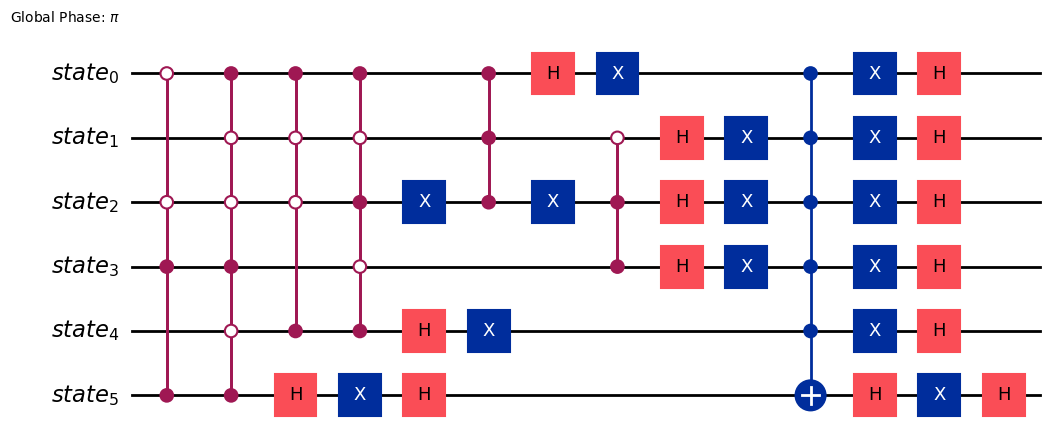

In [47]:
from qiskit import QuantumCircuit
from qiskit_algorithms import AmplificationProblem
from qiskit.circuit.library import PhaseOracle

log_expr = '((Ben & Lia) | (Martin & Mia) | (Ben & Feyling) | (Jack & Mia)) & ~(Lia & Martin)'
oracle = PhaseOracle(expression=log_expr)

# define Grover's algorithm
problem = AmplificationProblem(oracle)

# now we can have a look at the Grover operator that is used in running the algorithm
# (Algorithm circuits are wrapped in a gate to appear in composition as a block
# so we have to decompose() the op to see it expanded into its component gates.)
problem.grover_operator.decompose().draw(output="mpl")

In [46]:
from qiskit_algorithms import Grover
from qiskit_aer.primitives import Sampler


grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
print("Result type:", type(result))
print()
print("Success!" if result.oracle_evaluation else "Failure!")
print("Top measurement:", result.top_measurement)

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01001 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.18096 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.16904 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ElidePermutations - 0.01311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveDiagonalGatesBeforeMeasure - 0.01097 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveIdentityEquivalent - 0.23198 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.06795 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContractIdleWiresInControlFlow - 0.00381 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CommutativeCancellation - 0.43392 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ConsolidateBlocks - 6.32572 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Split2QUnitaries - 0.03314 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01001 (m

Result type: <class 'qiskit_algorithms.amplitude_amplifiers.grover.GroverResult'>

Success!
Top measurement: 11
